### Языковое моделирование

В широком смысле, языковое моделирование — это процесс формализации языка, в частности — естественного языка, чтобы сделать его машинно‑читаемым и обрабатывать различными способами. Таким образом, это касается не только генерации текста, но и представления языка.

В узком смысле, языковое моделирование — это процесс вычисления вероятности появления в предложении того или иного слова.

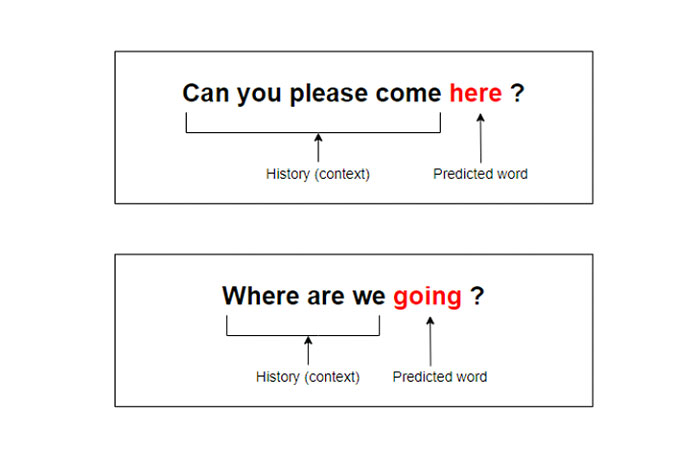

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk import WordPunctTokenizer
nltk.download('punkt')

from tqdm import tqdm
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Данные - корпус [ArXiv](http://arxiv.org/) статей с [kaggle](https://www.kaggle.com/neelshah18/arxivdataset/)


In [ ]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2025-02-27 17:34:55--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/0mulrothty5o8i8ud9gz2/arxivData.json.tar.gz?rlkey=n759u5qx2xpxxglmrl390vwvk&dl=1 [following]
--2025-02-27 17:34:55--  https://www.dropbox.com/scl/fi/0mulrothty5o8i8ud9gz2/arxivData.json.tar.gz?rlkey=n759u5qx2xpxxglmrl390vwvk&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf32ee61808f6e9180c3df14954.dl.dropboxusercontent.com/cd/0/inline/Ck4RSM5BCzK8N9PQleyRxFgwp1Ylc6xUj7m36DGno-r41k2QILKJVRFeBI1nTAR1o2JRmoeieda6AypTiE98QDt5bHI1ymyBws7U7xNNJq4--MEllDExad0t5DdyYv0EpVc/file?dl=1# [following]
--2025-02-27 17:34:59--  https://ucf32ee61808f6e9180c3df14954.dl.dropboxuse

,author,day,id,link,month,summary,tag,title,year
8681,"[{'name': 'Xiang Long'}, {'name': 'Chuang Gan'...",27,1711.09550v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",11,"Recently, substantial research effort has focu...","[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Attention Clusters: Purely Attention Based Loc...,2017
28091,"[{'name': 'Daniel Gordon'}, {'name': 'Ali Farh...",17,1705.06368v3,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Robust object tracking requires knowledge and ...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Re3 : Real-Time Recurrent Regression Networks ...,2017
15093,[{'name': 'Laurent Romary'}],1,1403.0052v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,This paper presents an attempt to customise th...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",TBX goes TEI -- Implementing a TBX basic exten...,2014
25197,"[{'name': 'Dinesh Jayaraman'}, {'name': 'Krist...",15,1506.04714v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,How can unlabeled video augment visual learnin...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Slow and steady feature analysis: higher order...,2015
30719,"[{'name': 'Dan Deng'}, {'name': 'Haifeng Liu'}...",4,1801.01315v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",1,Most state-of-the-art scene text detection alg...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",PixelLink: Detecting Scene Text via Instance S...,2018


In [ ]:
lines = data.apply(lambda x: x['title'] + ' ; ' + x['summary'].replace('\n', ' '), axis=1).tolist()
sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

### Токенизация

In [ ]:
tokenizer = WordPunctTokenizer()
lines = [' '.join(tokenizer.tokenize(line.lower())) for line in lines]
print(lines[0])

dual recurrent attention units for visual question answering ; we propose an architecture for vqa which utilizes recurrent layers to generate visual and textual attention . the memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question . our single model outperforms the first place winner on the vqa 1 . 0 dataset , performs within margin to the current state - of - the - art ensemble model . we also experiment with replacing attention mechanisms in other state - of - the - art models with our implementation and show increased accuracy . in both cases , our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the vqa dataset .


### N-Gram Language Model

Language model (языковая модель) - вероятностная модель, оценивающая вероятность текста:

$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$

Фактически вероятность последнего токена равна $P(w_T \mid w_1, \dots, w_{T-1})$ и зависит от $n-1$ предыдущих токенов, что очень неудобно считать на практике.

Популярная апроксимация - предположить, что вероятность последнего токена зависит только от некоторого конечного числа предыдущих (n-gram model):

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Создадим модель, которая считает встречаемости токенов при условии предыдущих n-1 токенов

In [ ]:
# - unk  - Unkwnown
# - eos - end of sentence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occured after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2}}
    """
    counts = defaultdict(Counter)
    for line in lines:
      unks = UNK + ' '
      unks = unks * (n - 1)
      line = f'{unks}' + line + f' {EOS}' # empty prefix: "" -> (UNK, UNK)
      tokens = line.split()
      for i in range(n - 1, len(tokens)):
        words = tokens[i - (n - 1) : i]
        word3 = tokens[i]
        counts[tuple(words)][word3] += 1
    return counts


Теперь мы можем построить вероятностную n-gram модель:

$$ P(w_t | prefix) = { Count(prefix, w_t) \over \sum_{\hat w} Count(prefix, \hat w) } $$

In [ ]:
class NGramLanguageModel:
    def __init__(self, lines, n):
        """
        Train a simple count-based language model:
        compute probabilities P(w_t | prefix) given ngram counts

        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n

        counts = count_ngrams(lines, self.n)
        self.probs = defaultdict(Counter)
        for prefix, token_counts in counts.items():
          sum_counts = sum(token_counts.values())
          self.probs[(prefix)] = {
              word3: token_count / sum_counts
              for word3, token_count in token_counts.items()
          }

    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : it's probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [UNK] * (self.n - 1 - len(prefix)) + prefix

        return self.probs[tuple(prefix)]

    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

"Тренировка" на всем датасете

In [ ]:
%%time

lm = NGramLanguageModel(lines, n=3)

CPU times: user 21.8 s, sys: 1.15 s, total: 23 s
Wall time: 24.4 s


### Генерация и сэмплирование

Процесс генерации текста последовательный (=авторегрессионный) - итеративно сэмплируем следующий токен:

* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$

Также можно брать самый вероятный токен среди top-k токенов:

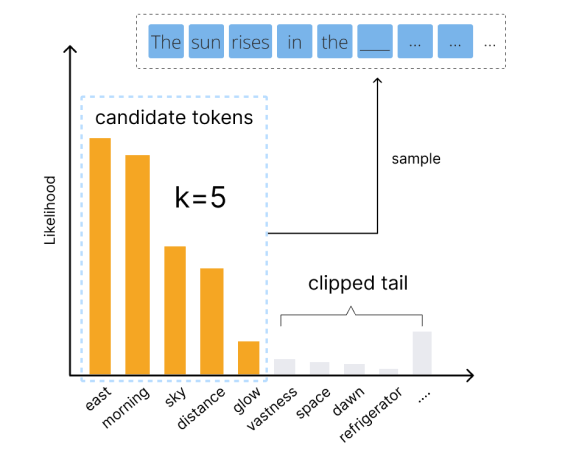

Или сэмлировать с температурой:

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{\hat w} P(\hat w | X) ^ {1 / \tau}}$$

Где $\tau > 0$ - температура. Если $\tau << 1$, более вероятные токены будут сэмплироваться с большей вероятностью, а менее вероятные - с меньшей.

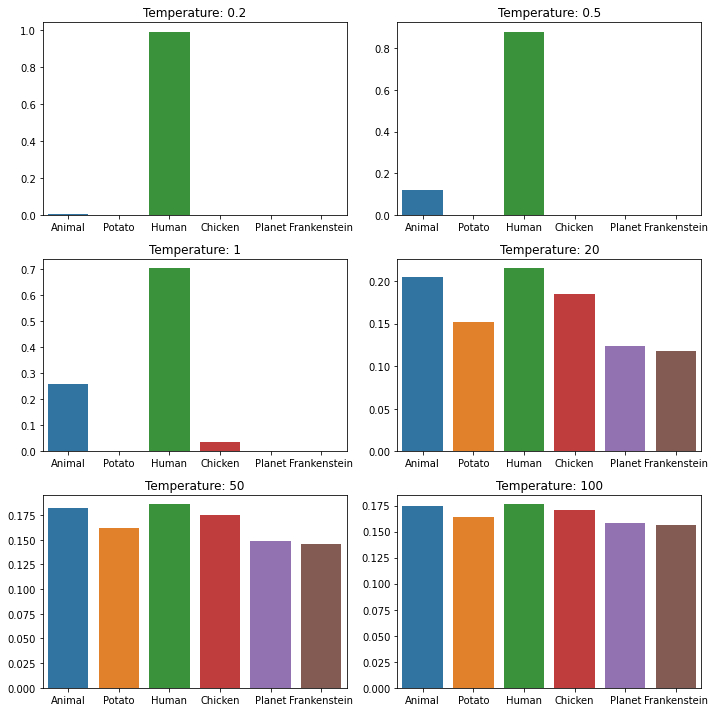

In [ ]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    possible_next_tokens = lm.get_possible_next_tokens(prefix)
    tokens, tokens_probs = zip(*possible_next_tokens.items())

    if temperature == 0:
        return tokens[np.argmax(tokens_probs)]

    tokens_probs = np.array(tokens_probs) ** (1 / temperature)
    tokens_probs /= tokens_probs.sum()
    return np.random.choice(tokens, p=tokens_probs)

Посмотрим, что в итоге получилось

In [ ]:
prefix = 'nlp is a'

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break

print(prefix)

nlp is a popular framework for decomposing the model to train the dialogue from step to improve the performance of our model on two consequent datasets from different computer vision pipeline for multi - disciplinary review of the k most similar search direction is formulated here as a " black box oracles which allow building of and ' indistinguishability ' - viz ., polygonal approximation based in particular , we arrive at the microscopic structure , run - time will be introduced by reil ( 1999 )) exploit an unstructured random noise . this model the document should also focus on a dataset


In [ ]:
prefix = 'n-gram model is the best language model for ' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.5)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break

print(prefix)

n-gram model is the best language model for  the case of the problem of finding a sparse and low - level data , we propose a new method is based on the other hand , the proposed method is tested on a large - scale data . _EOS_


### Оценка LM: perplexity

Perplexity (перплексия) - мера того, как хорошо модель аппроксимирует распределение данных  - обратная вероятность тестового набора, нормализованная по количеству слов. **Чем меньше перплексия, тем модель лучше**


$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$

На уровне корпуса перплексия - произведение вероятностей всех токенов во всех предложениях в степени 1 / длину всех предложений в корпусе.

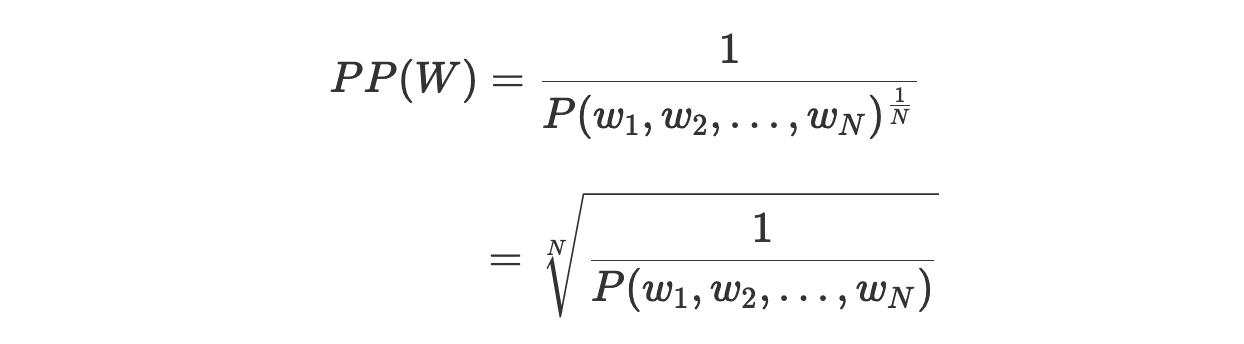

Для удобства можно считать log-perplexity (из log-вероятностей) и потом взять экспоненту

In [ ]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    """
    perplexity = 0.0
    n = 0
    ngram_count = lm.n
    for line in lines:
      tokens = line.split()
      for i, next_token in enumerate(tokens):
        if i >= ngram_count:
          prefix = ' '.join(tokens[i - ngram_count + 1 : i])
        elif i == 0:
          prefix = ''
        else:
          prefix = ' '.join(tokens[: i])
        perplexity += np.maximum(np.log(lm.get_next_token_prob(prefix, next_token)), min_logprob)
        n += 1

        if i == (len(tokens) - 1):
          prefix = ' '.join(tokens[i - ngram_count + 2 : i + 1])
          perplexity += np.maximum(np.log(lm.get_next_token_prob(prefix, EOS)), min_logprob)
          n += 1
    return np.exp(-perplexity / n)

In [ ]:
np.seterr(divide='ignore');

In [ ]:
dummy_lines = sorted(lines, key=len)[:100]

lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])  # thanks, L. Carrol

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184


Сделаем сплит данных, обучим модель на train-части и оценим перплексию на test

In [ ]:
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 1832.23136
N = 2, Perplexity = 85653987.28774
N = 3, Perplexity = 61999196259043346743296.00000


### Сглаживание

Проблема в `NGramLanguageModel` - когда она встречает n-грамму, которую раньше не видела, ей назначается вероятность 0.

Для решения этой проблемы можно применить сглаживание. Ключевая идея - модифицировать count'ы таким образом, чтобы вероятность не стала слишком маленькой. Простейший способ - аддитивное сглаживание:

$$ P(w_t | prefix) = { Count(prefix, w_t) + \delta \over \sum_{\hat w} (Count(prefix, \hat w) + \delta) } $$

Если count'ы префикса слишком маленькие, аддитивное сглаживание скорректирует вероятности, сделав их более равномерными